### Arsitektur Model

    +----------------------------+
    |    Data Preprocessing      |
    |  (Reading & Cleaning Text) |
    +-------------+--------------+
                  |
                  v
    +----------------------------+
    |       Tokenization         |
    | (Byte Pair Encoding - BPE) |
    +-------------+--------------+
                  |
                  v
    +----------------------------+
    |   BPE Token to Index       |
    |   (Creating Vocabulary)    |
    +-------------+--------------+
                  |
                  v
    +----------------------------+
    |      Transformer Model     |
    |  (Embedding + Positional   |
    |    Encoding + Decoder)     |
    +-------------+--------------+
                  |
                  v
    +----------------------------+
    |        Training Loop       |
    |  (Using DataLoader for     |
    |  Batched Training)         |
    +-------------+--------------+
                  |
                  v
    +----------------------------+
    |         Evaluation         |
    | (Using Metrics like BLEU)  |
    +----------------------------+
                  |
                  v
    +----------------------------+
    |         Deployment         |
    |  (Server/Web Application)  |
    +----------------------------+


### Membaca dan Membersihkan Teks

In [5]:
import os

def read_text_files(folder_path):
    texts = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                content = file.read().strip()
                if content:  # Check if the file is not empty
                    cleaned_content = clean_text(content)
                    texts.append(cleaned_content)
    return texts

def clean_text(text):
    # Remove unwanted characters
    unwanted_chars = ['*', '#', '_', ')', '(', '!', '?', '.', ',', '-']
    for char in unwanted_chars:
        text = text.replace(char, '')
    return text

folder_path = './Dataset/nlp_dataset'
texts = read_text_files(folder_path)


In [8]:
def count_txt_files(folder_path):
    return sum(1 for filename in os.listdir(folder_path) if filename.endswith(".txt"))

folder_path = './Dataset/nlp_dataset'

num_files = count_txt_files(folder_path)
print(f"Number of .txt files in folder: {num_files}")

Number of .txt files in folder: 1000


In [6]:
texts = read_text_files(folder_path)
print(f"Number of texts read: {len(texts)}")

Number of texts read: 341


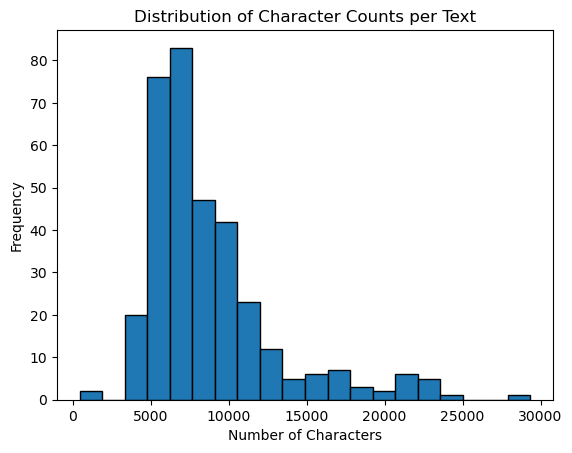

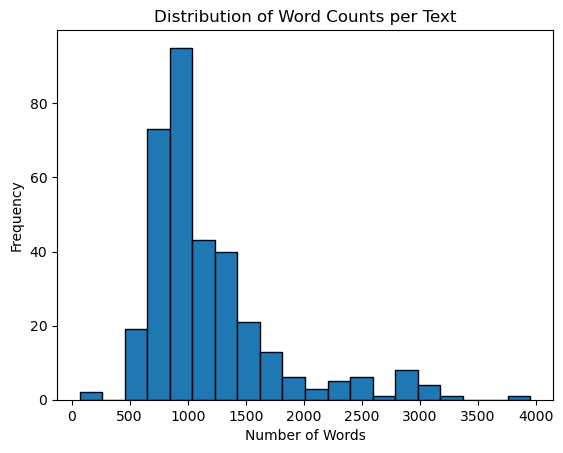

In [7]:
import matplotlib.pyplot as plt

# Visualisasi jumlah karakter per teks
char_counts = [len(text) for text in texts]
plt.hist(char_counts, bins=20, edgecolor='black')
plt.title('Distribution of Character Counts per Text')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

# Visualisasi jumlah kata per teks
word_counts = [len(text.split()) for text in texts]
plt.hist(word_counts, bins=20, edgecolor='black')
plt.title('Distribution of Word Counts per Text')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

### Tokenisasi BPE

In [10]:
import re
from collections import Counter, defaultdict

def get_vocab(texts):
    vocab = Counter()
    for text in texts:
        words = re.findall(r'\b\w+\b', text.lower())
        for word in words:
            vocab[' '.join(list(word)) + ' </w>'] += 1
    return vocab

vocab = get_vocab(texts)

def get_stats(vocab):
    pairs = defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols) - 1):
            pairs[symbols[i], symbols[i + 1]] += freq
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = ' '.join(pair)
    replacement = ''.join(pair)
    for word in v_in:
        w_out = word.replace(bigram, replacement)
        v_out[w_out] = v_in[word]
    return v_out

num_merges = 10000
for i in range(num_merges):
    pairs = get_stats(vocab)
    if not pairs:
        break
    best = max(pairs, key=pairs.get)
    vocab = merge_vocab(best, vocab)

# Membuat kamus token ke indeks
token_vocab = {word.replace(' ', ''): i for i, word in enumerate(vocab.keys(), start=2)}
token_vocab['<pad>'] = 0
token_vocab['<unk>'] = 1

# Membalik kamus dari indeks ke token
inv_token_vocab = {idx: word for word, idx in token_vocab.items()}


### Mengubah Teks Menjadi Indeks

In [12]:
def tokenize_bpe(texts, token_vocab):
    tokenized_texts = []
    for text in texts:
        words = re.findall(r'\b\w+\b', text.lower())
        tokenized = []
        for word in words:
            token = ''.join([c if c in token_vocab else '<unk>' for c in word])
            tokenized.append(token_vocab.get(token, token_vocab['<unk>']))
        tokenized_texts.append(tokenized)
    return tokenized_texts

encoded_texts_bpe = tokenize_bpe(texts, token_vocab)


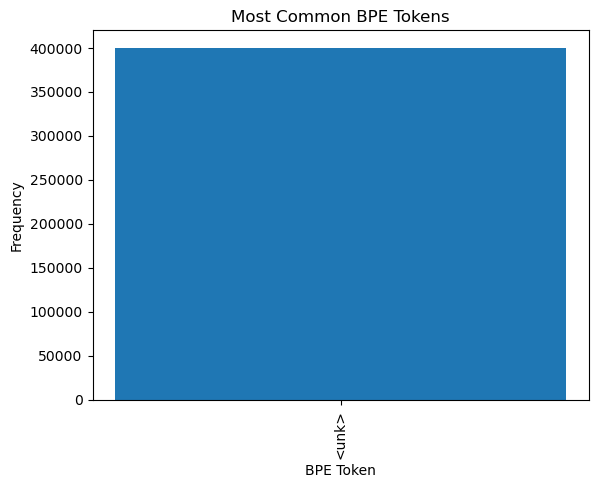

In [13]:
# Menghitung frekuensi token BPE
token_frequencies = Counter()
for encoded_text in encoded_texts_bpe:
    token_frequencies.update(encoded_text)

# Mengambil 30 token paling umum
most_common_tokens = token_frequencies.most_common(30)
tokens, frequencies = zip(*most_common_tokens)

# Visualisasi frekuensi token BPE
plt.bar(tokens, frequencies, tick_label=[inv_token_vocab[token] for token in tokens])
plt.title('Most Common BPE Tokens')
plt.xlabel('BPE Token')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


### Definisi Model Transformer

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_decoder_layers, dim_feedforward, max_seq_length, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_seq_length)
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_decoder_layers)
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.d_model = d_model
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc_out.weight.data.uniform_(-initrange, initrange)
        self.fc_out.bias.data.zero_()

    def forward(self, input_ids, attention_mask=None):
        embedded = self.embedding(input_ids) * math.sqrt(self.d_model)
        embedded = self.pos_encoder(embedded)
        
        embedded = embedded.permute(1, 0, 2)  # Transformer expects shape [seq_len, batch_size, d_model]
        memory = embedded  # For decoder-only, memory is the embedded input

        output = self.transformer_decoder(embedded, memory)
        output = self.fc_out(output)
        return output.permute(1, 0, 2)  # Return shape [batch_size, seq_len, vocab_size]

vocab_size = len(token_vocab)
d_model = 512
nhead = 8
num_decoder_layers = 6
dim_feedforward = 2048
max_seq_length = 512
dropout = 0.1

model = TransformerModel(vocab_size, d_model, nhead, num_decoder_layers, dim_feedforward, max_seq_length, dropout)


### Membuat DataLoader

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader

class BPEDataset(Dataset):
    def __init__(self, encoded_texts, max_length=512):
        self.encoded_texts = encoded_texts
        self.max_length = max_length

    def __len__(self):
        return len(self.encoded_texts)

    def __getitem__(self, idx):
        input_ids = self.encoded_texts[idx]
        if len(input_ids) < self.max_length:
            input_ids = input_ids + [token_vocab['<pad>']] * (self.max_length - len(input_ids))
        else:
            input_ids = input_ids[:self.max_length]
        
        return torch.tensor(input_ids)

bpe_dataset = BPEDataset(encoded_texts_bpe)
bpe_dataloader = DataLoader(bpe_dataset, batch_size=4, shuffle=True)


### Training Model

In [16]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

# Hyperparameters
epochs = 10
learning_rate = 5e-5

# Optimizer and Loss Function
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = CrossEntropyLoss(ignore_index=token_vocab['<pad>'])

# Training Loop
model.train()
for epoch in range(epochs):
    for batch in bpe_dataloader:
        input_ids = batch
        
        optimizer.zero_grad()
        outputs = model(input_ids)
        
        # Use reshape instead of view
        loss = criterion(outputs.reshape(-1, vocab_size), input_ids.reshape(-1))
        loss.backward()
        optimizer.step()

        print(f"Epoch: {epoch+1}, Loss: {loss.item()}")


Epoch: 1, Loss: 10.261481285095215
Epoch: 1, Loss: 5.720875263214111
Epoch: 1, Loss: 1.8456041812896729
Epoch: 1, Loss: 0.15707124769687653
Epoch: 1, Loss: 0.01274193823337555
Epoch: 1, Loss: 0.0019439439056441188
Epoch: 1, Loss: 0.00046702788677066565
Epoch: 1, Loss: 0.00015248949057422578
Epoch: 1, Loss: 6.157776806503534e-05
Epoch: 1, Loss: 7.412327249767259e-05
Epoch: 1, Loss: 1.644218536966946e-05
Epoch: 1, Loss: 1.0112830750586e-05
Epoch: 1, Loss: 6.7553241933637764e-06
Epoch: 1, Loss: 4.744611032947432e-06
Epoch: 1, Loss: 3.5248745007265825e-06
Epoch: 1, Loss: 2.7085152396466583e-06
Epoch: 1, Loss: 2.1730058961111354e-06
Epoch: 1, Loss: 1.7875554476631805e-06
Epoch: 1, Loss: 1.5385433016490424e-06
Epoch: 1, Loss: 1.2845840728914482e-06
Epoch: 1, Loss: 1.0492508408788126e-06
Epoch: 1, Loss: 9.094945880860905e-07
Epoch: 1, Loss: 8.568167118028214e-07
Epoch: 1, Loss: 8.380738449886849e-07
Epoch: 1, Loss: 8.356873308912327e-07
Epoch: 1, Loss: 8.331844014719536e-07
Epoch: 1, Loss: 8.

### VISUALIZE

In [14]:
# Untuk mencatat loss selama pelatihan
losses = []

# Training Loop dengan pencatatan loss
model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for batch in bpe_dataloader:
        input_ids = batch
        
        optimizer.zero_grad()
        outputs = model(input_ids)
        
        # Use reshape instead of view
        loss = criterion(outputs.reshape(-1, vocab_size), input_ids.reshape(-1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(bpe_dataloader)
    losses.append(avg_loss)
    print(f"Epoch: {epoch+1}, Loss: {avg_loss}")

# Visualisasi loss selama pelatihan
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()


NameError: name 'model' is not defined

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [1]:
import torch
print(torch.__version__)


2.4.0


In [1]:
import torch
print("PyTorch Version: ", torch.__version__)
print("CUDA Available: ", torch.cuda.is_available())
print("CUDA Version: ", torch.version.cuda)


PyTorch Version:  2.4.0
CUDA Available:  False
CUDA Version:  None
